In [2]:
from os import listdir
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from PIL import Image
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
def load_photos(directory):
    images = []
    labels = []
    for name in listdir(directory):
        filename = directory + '/' + name
        # load an image from file
        image = load_img(filename, target_size=(128, 160))
        # convert the image pixels to a numpy array
        image = img_to_array(image)
        # get image id + labels
        value = int(name.split('_')[0])
        labels.append(value)
        images.append(image)
    return images, labels

In [11]:
# load images from both train and test groups
directory = '../data/Dataset-tg-1/Train'
images, labels = load_photos(directory)
nb_images = len(images)
print('Loaded Images and labels for training: %d' % nb_images)
directory = '../data/Dataset-tg-1/Val'
images_val, labels_val = load_photos(directory)
nb_images_val = len(images_val)
print('Loaded Images and labels for validation: %d' % nb_images_val)

Loaded Images and labels for training: 380
Loaded Images and labels for validation: 61


In [12]:
#normalise datas
images = np.array(images)
images = images[:, 40:, :, :]
images /= 255
images_val = np.array(images_val)
images_val = images_val[:, 40:, :, :]
images_val /= 255

((380, 88, 160, 3), <matplotlib.image.AxesImage at 0x125787b00>)

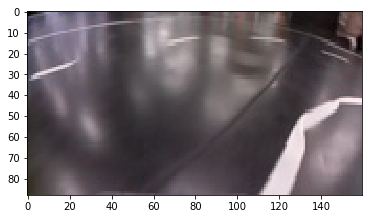

In [14]:
images.shape, plt.imshow(images[50])


In [15]:
#convert labels to np.array
labels = np.array(labels)
labels_val = np.array(labels_val)

In [16]:
#convert datas to dummyvalues
labelsd = pd.get_dummies(labels)

In [17]:
labelsd.shape
labelsd

,1,2,3
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0
5,1,0,0
6,1,0,0
7,1,0,0
8,1,0,0
9,1,0,0


In [18]:
#convert to np.array again
labelsd = np.array(labelsd)

In [19]:
#check if OK
labels[1], labelsd[1]

(1, array([1, 0, 0], dtype=uint8))

In [20]:
from keras.models import Model, Sequential
from keras.layers import *
import keras.backend as K
import keras.optimizers as Optimizers

In [22]:
K.clear_session()

img_in = Input(shape=(88, 160, 3), name='img_in')

x = img_in

x = Convolution2D(24, (5,5), strides=(2,2), activation='relu')(x)       # 24 features, 5 pixel x 5 pixel kernel (convolution, feauture) window, 2wx2h stride, relu activation
x = Convolution2D(32, (5,5), strides=(2,2), activation='relu')(x)       # 32 features, 5px5p kernel window, 2wx2h stride, relu activatiion
x = Convolution2D(64, (5,5), strides=(2,2), activation='relu')(x)       # 64 features, 5px5p kernal window, 2wx2h stride, relu
x = Convolution2D(64, (3,3), strides=(2,2), activation='relu')(x)       # 64 features, 3px3p kernal window, 2wx2h stride, relu

# Possibly add MaxPooling (will make it less sensitive to position in image).  Camera angle fixed, so may not to be needed

x = Flatten(name='flattened')(x)                                        # Flatten to 1D (Fully connected)
x = Dense(100, activation='relu')(x)                                    # Classify the data into 100 features, make all negatives 0
x = Dropout(.1)(x)                                                      # Randomly drop out (turn off) 10% of the neurons (Prevent overfitting)
x = Dense(50, activation='relu')(x)                                     # Classify the data into 50 features, make all negatives 0
x = Dropout(.1)(x)                                                      # Randomly drop out 10% of the neurons (Prevent overfitting)

#categorical output
out = Dense(3, activation='softmax')(x)

model = Model(inputs=[img_in], outputs=[out])
model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])

In [24]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img_in (InputLayer)          (None, 88, 160, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 42, 78, 24)        1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 19, 37, 32)        19232     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 17, 64)         51264     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 8, 64)          36928     
_________________________________________________________________
flattened (Flatten)          (None, 1536)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               153700    
__________

In [25]:
h = model.fit(images, labelsd, batch_size=1, epochs=50, verbose=1)

Epoch 1/50
380/380 [==============================] - 5s - loss: 1.0857 - acc: 0.4421     
Epoch 2/50
380/380 [==============================] - 5s - loss: 1.0266 - acc: 0.5158     
Epoch 3/50
380/380 [==============================] - 5s - loss: 0.8744 - acc: 0.6263     
Epoch 4/50
380/380 [==============================] - 6s - loss: 0.7456 - acc: 0.7053     
Epoch 5/50
380/380 [==============================] - 6s - loss: 0.6929 - acc: 0.7684     
Epoch 6/50
380/380 [==============================] - 5s - loss: 0.6052 - acc: 0.7737     
Epoch 7/50
380/380 [==============================] - 5s - loss: 0.5240 - acc: 0.8211     
Epoch 8/50
380/380 [==============================] - 6s - loss: 0.4513 - acc: 0.8421     
Epoch 9/50
380/380 [==============================] - 6s - loss: 0.4006 - acc: 0.8474     
Epoch 10/50
380/380 [==============================] - 6s - loss: 0.3563 - acc: 0.8737     
Epoch 11/50
380/380 [==============================] - 5s - loss: 0.2810 - acc: 0.9026   

KeyboardInterrupt: 

In [26]:
#print History graph
historydf = pd.DataFrame(h.history, index=h.epoch)
historydf.plot(ylim=(0,1))

NameError: name 'h' is not defined

In [29]:
# Get predictions
all_preds = model.predict(images_val)

# Check predictions
idx = np.argmax(all_preds, axis=1)

i = 0
for value in idx:
    idx[i] = value + 1
    i = i + 1

idx, labels_val

(array([1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 1, 2, 2, 2, 3, 2,
        2, 2, 1, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3,
        3, 3, 2, 3, 3, 3, 2, 3, 1, 1, 2, 3, 3, 3, 2]),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]))

In [30]:
import math
i = 0
res = 0
for value in idx:
    if value != labels_val[i]:
        res = res + 1
    i = i + 1
res/i

0.2459016393442623

In [31]:
model.save('model-tg-1.h5')